# CSE 258, Fall 2019: Homework 1
## Kristoffer Gjerde

Dataset is downloaded from https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Gift_Card_v1_00.tsv.gz   
It is a TSV formated dataset, including reviews from one of the smaller Amazon categories. 

In [1]:
import numpy as np
import urllib
import scipy.optimize
import random
import gzip

In [2]:
path = "./resources/amazon_reviews_us_Gift_Card_v1_00.tsv.gz"
f = gzip.open(path, "rt", encoding="utf8")

In [3]:
dataset = []
header = f.readline().strip().split("\t")
for line in f:
    line = line.split("\t")
    d = dict(zip(header, line))
    d['star_rating'] = int(d['star_rating'])
    # Here you can also select only the fields you want to use
    #fields = [...]
    #d2 = {field: d[field] for field in fields}
    dataset.append(d)

In [4]:
dataset[0]

{'marketplace': 'US',
 'customer_id': '24371595',
 'review_id': 'R27ZP1F1CD0C3Y',
 'product_id': 'B004LLIL5A',
 'product_parent': '346014806',
 'product_title': 'Amazon eGift Card - Celebrate',
 'product_category': 'Gift Card',
 'star_rating': 5,
 'helpful_votes': '0',
 'total_votes': '0',
 'vine': 'N',
 'verified_purchase': 'Y',
 'review_headline': 'Five Stars',
 'review_body': 'Great birthday gift for a young adult.',
 'review_date': '2015-08-31\n'}

# Regression (week 1)

### Task 1 
What is the distribution of ratings in the dataset? That is, how many 1-star, 2-star, 3-star (etc.) reviews are there? You may write out the values or include a simple plot.

In [5]:
from collections import defaultdict
# First let us get the counts
ratings_count = defaultdict(int)
for d in dataset:
    ratings_count[d['star_rating']] += 1
ratings_count

defaultdict(int, {5: 129709, 1: 4793, 4: 9859, 2: 1569, 3: 3156})

In [6]:
import matplotlib.pyplot as plt
def categorical_plot(names, *dicts):
    #plt.figure(figsize=(10, 5))
    plt.title('Distribution of ratings')
    for i, d in enumerate(dicts):
        items = sorted(d.items()) 
        category, value = zip(*items)
        plt.bar(category, value, width=0.5, label=names[i])
    plt.legend(loc='best')
    plt.show()

categorical_plot(["unfiltered"], ratings_count)

<Figure size 640x480 with 1 Axes>

### Task 2
Repeat the above question, but generate the distribution (a) only for reviews that are ‘verified,’ and (b) only for reviews that are not verified. Write out the values or generate a plot to show
the difference between these distributions.

In [7]:
ratings_count_verified, ratings_count_notverified = defaultdict(int), defaultdict(int)
for d in dataset:
    if d['verified_purchase'] == 'Y':
        ratings_count_verified[d['star_rating']] += 1
    else:
        ratings_count_notverified[d['star_rating']] += 1
ratings_count_verified, ratings_count_notverified

(defaultdict(int, {5: 118974, 1: 4000, 4: 8940, 2: 1344, 3: 2784}),
 defaultdict(int, {5: 10735, 4: 919, 3: 372, 1: 793, 2: 225}))

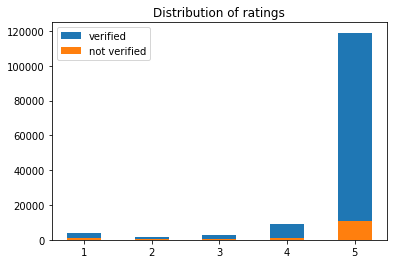

In [8]:
categorical_plot(["verified", "not verified"], ratings_count_verified, ratings_count_notverified)

### Task 3
Train a simple predictor to predict the star rating using two features.
Report the values of θ0, θ1, and θ2. Briefly describe your interpretation of these values, i.e., what do θ0,
θ1, and θ2 represent? Explain these in terms of the features and labels, e.g. if the coefficient of ‘review
length’ is negative, what would that say about verified versus unverified reviews 

In [9]:
def feature(datum):
    return [1, datum['verified_purchase'] == 'Y', len(datum['review_body'])]
    
    
X = [feature(d) for d in dataset]
y = [d['star_rating'] for d in dataset]
theta,residuals,rank,s = np.linalg.lstsq(X, y)
theta

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


array([ 4.84461817e+00,  5.04148265e-02, -1.24659895e-03])

### Task 4
Train another predictor that only uses one feature. Report the values of θ0 and θ1. Note that coefficient you found here might be quite different (i.e., much
larger or smaller) than the one from Question 3, even though these coefficients refer to the same feature.
Provide an explanation as to why these coefficients might vary so significantly

In [10]:
def feature(datum):
    return [1, datum['verified_purchase'] == 'Y']
    
X = [feature(d) for d in dataset]
y = [d['star_rating'] for d in dataset]
theta,residuals,rank,s = np.linalg.lstsq(X, y)
theta

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


array([4.57758356, 0.16852426])

### Task 5
Split the data into two fractions – the first 90% for training, and the remaining 10% testing (based on
the order they appear in the file). Train the same model as in Question 4 on the training set only. What
is the model’s MSE on the training and on the test set?

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=False)
theta,residuals,rank,s = np.linalg.lstsq(X_train, y_train)

def predict(thetas, features):
    return thetas[0] + sum(thetas[x] * features[x-1] for x in range(1, len(thetas)))

def mse_train_and_test(theta, X_train, X_test):
    y_train_pred = [predict(theta, features) for features in X_train]
    y_test_pred = [predict(theta, features) for features in X_test]

    l_train, l_test = len(X_train), len(X_test)
    mse_train = sum((y_train_pred[x] - y_train[x])**2 for x in range(l_train)) / l_train
    mse_test = sum((y_test_pred[x] - y_test[x])**2 for x in range(l_test)) / l_test
    return mse_train, mse_test

mse_train, mse_test = mse_train_and_test(theta, X_train, X_test)
mse_train, mse_test


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


(0.6606575613336154, 0.9375979578417207)

### Task 6
Using the test set from Question 5, report the Mean Absolute Error (MAE) and R2
coefficient for your predictor (on the test set).



In [12]:
l_train, l_test = len(X_train), len(X_test)
y_test_pred = [predict(theta, features) for features in X_test]

# Mean Absolute Error
mae_test = sum(abs((y_test_pred[x] - y_test[x])) for x in range(l_test)) / l_test

# R^2 Coefficient
mean_pred = sum(y_test_pred) / l_test
var = sum((y_test_pred[x] - mean_pred)**2 for x in range(l_test)) / l_test
r2_test = 1 - (mse_test)

mae_test, r2_test


(0.5201189466718115, 0.06240204215827927)

### Task 7
Repeat the above experiment, varying the size of the training and test fractions between
5% and 95% for training (using the complement for testing). Show how the training and test error vary
as a function of the training set size (again using a simple plot or table). Does the size of the training
set make a significant difference in testing performance? Comment on why it might or might not make
a significant difference in this instance 

In [13]:
train_sizes = np.arange(5, 100, 5)

traning_errors, test_errors = [], []
for train_size in train_sizes:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1-train_size)) # Uses shuffle this time
    
    # Train the model
    theta,residuals,rank,s = np.linalg.lstsq(X_train, y_train)
    
    # Calculate the error
    mse_train, mse_test = mse_train_and_test(theta, X_train, X_test)
    traning_errors.append(mse_train)
    test_errors.append(mse_test)
traning_errors[:2], test_errors[:2]
    

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


([0.1875, 1.5802469135802468], [0.6881053715404944, 0.7700180128975083])

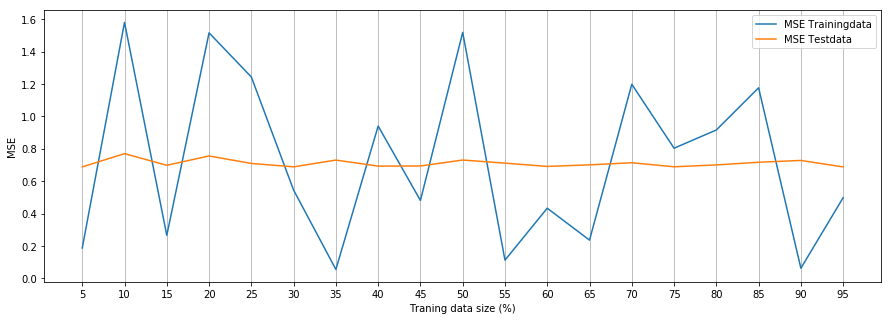

In [14]:
# Plot them to see how the MSE changes as the size of the trnaingdata change
plt.figure(figsize=(15,5))
plt.plot(train_sizes, traning_errors, label="MSE Trainingdata")
plt.plot(train_sizes, test_errors, label="MSE Testdata")
plt.legend(loc='best')
axs = plt.gca()
axs.xaxis.grid(True)
axs.set_xlabel('Traning data size (%)')
axs.set_ylabel('MSE')
plt.xticks(train_sizes)
plt.show()

# Classification
In this question we’ll alter the prediction from our regression task, so that we are now classifying whether a
review is verified. Continue using the 90%/10% training and test sets you constructed previously, i.e., train on
the training set and report the error/accuracy on the testing set.

### Task 8
First, let’s train a predictor that estimates whether a review is verified using the rating and the length. Train a logistic regressor to make the above prediction (you may use a logistic regression library with default parameters, e.g. linear model.LogisticRegression() from sklearn). Report the classification accuracy
of this predictor. Report also the proportion of labels that are positive (i.e., the proportion of reviews
that are verified) and the proportion of predictions that are positive.

In [15]:
def feature(datum):
    return [1, datum['star_rating'], len(datum['review_body'])]

X = [feature(d) for d in dataset]
y = [d['verified_purchase'] == 'Y' for d in dataset]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=False)

In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X, y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
predictions  = model.predict(X_test)
correctPredictions = predictions == y_test
l_test = len(y_test)
accuracy = sum(correctPredictions / l_test)
positive_labels = sum(y_test)
positive_predictions = sum(predictions)
print("\n Accuracy: {} \n Positive labels: {} \n Positive predictions : {}".format(accuracy, positive_labels, positive_predictions))



 Accuracy: 0.5573143738681698 
 Positive labels: 8329 
 Positive predictions : 14755


In [18]:
dataset[0]

{'marketplace': 'US',
 'customer_id': '24371595',
 'review_id': 'R27ZP1F1CD0C3Y',
 'product_id': 'B004LLIL5A',
 'product_parent': '346014806',
 'product_title': 'Amazon eGift Card - Celebrate',
 'product_category': 'Gift Card',
 'star_rating': 5,
 'helpful_votes': '0',
 'total_votes': '0',
 'vine': 'N',
 'verified_purchase': 'Y',
 'review_headline': 'Five Stars',
 'review_body': 'Great birthday gift for a young adult.',
 'review_date': '2015-08-31\n'}

### Task 9
Considering same prediction problem as above, can you come up with a more accurate predictor (e.g. using
features from the text, timestamp, etc.)? Write down the feature vector you design, and report its
train/test accuracy.

In [19]:
def feature(datum):
    return [1, int(datum['helpful_votes']), int(datum['total_votes']), len(datum['review_body']) > 100]

# Split data
X = [feature(d) for d in dataset]
y = [d['verified_purchase'] == 'Y' for d in dataset]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=False)

# Train model
model = LogisticRegression()
model.fit(X, y)

# Do predictions
predictions  = model.predict(X_test)
correctPredictions = predictions == y_test
l_test = len(y_test)
accuracy = sum(correctPredictions / l_test)
positive_labels = sum(y_test)
positive_predictions = sum(predictions)
print("\n Accuracy: {} \n Positive labels: {} \n Positive predictions : {}".format(accuracy, positive_labels, positive_predictions))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



 Accuracy: 0.5590582869408096 
 Positive labels: 8329 
 Positive predictions : 14885
